# Regression Project

## GOALS:

• To predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.

• Recommend on a ways to make a better model.

• Find what states and counties are the property located in.

## IMPORTS

In [1]:
# Standard imports
import numpy as np
import pandas as pd

# My imports
import wrangle as w
import explore as e
import modeling as m

from pydataset import data
from scipy import stats


import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## AQUIRE

• Got the data from the Zillow database in MySQL.

• The dataset that was pulled initially had 52,442 rows and 8 different features, the dataset including property information and details about the properties.

• Each row in the dataset represents a single-family property with transactions in 2017.

• Each column in the dataset represents a specific feature of the property.

## PREPARE

• Prepared the data by applying a series of transformations, removing unnecessary columns, adding new columns as needed for further exploration, and renaming some columns for clarity.

• Also performed some data cleaning steps to ensure the dataset's quality. Specifically, I dropped any nulls, checked for missing values and duplicates, and removed outliers bathrooms, yearbuilt, area, and property_value.

• To make the dataset more consistent, I changed features from float to int, encoded the county feature, and rearranged the columns.

• Once all this was done, we were left with only 47,347 rows, so 5,095 rows were removed. 

• For further exploration, a data frame prepared CSV file was also created.


In [2]:
df, prep_df = w.get_zillow_data()

csv file found and loaded


In [3]:
df.shape

(47347, 8)

## Data Dictionary

| Features | Definition |
| --- | --- |
| bedrooms | Number of bedrooms |
| bathrooms | Number of bathrooms |
| area | Area of the house in square footage |
| yearbuilt | The year the property was built |
| county | The county were the properies are located |
| county_Orange | Orange county - where the property is located |
| county_Ventura | Ventura county - where the property is located |
| property_value | property tax assessed value in dollars |

In [4]:
target = 'property_value'

In [5]:
tr, val, ts = w.get_split(df)

In [6]:
tr.shape, val.shape, ts.shape

((28407, 8), (9470, 8), (9470, 8))

In [7]:
# no data sample was used at the end
tr_smpl = tr

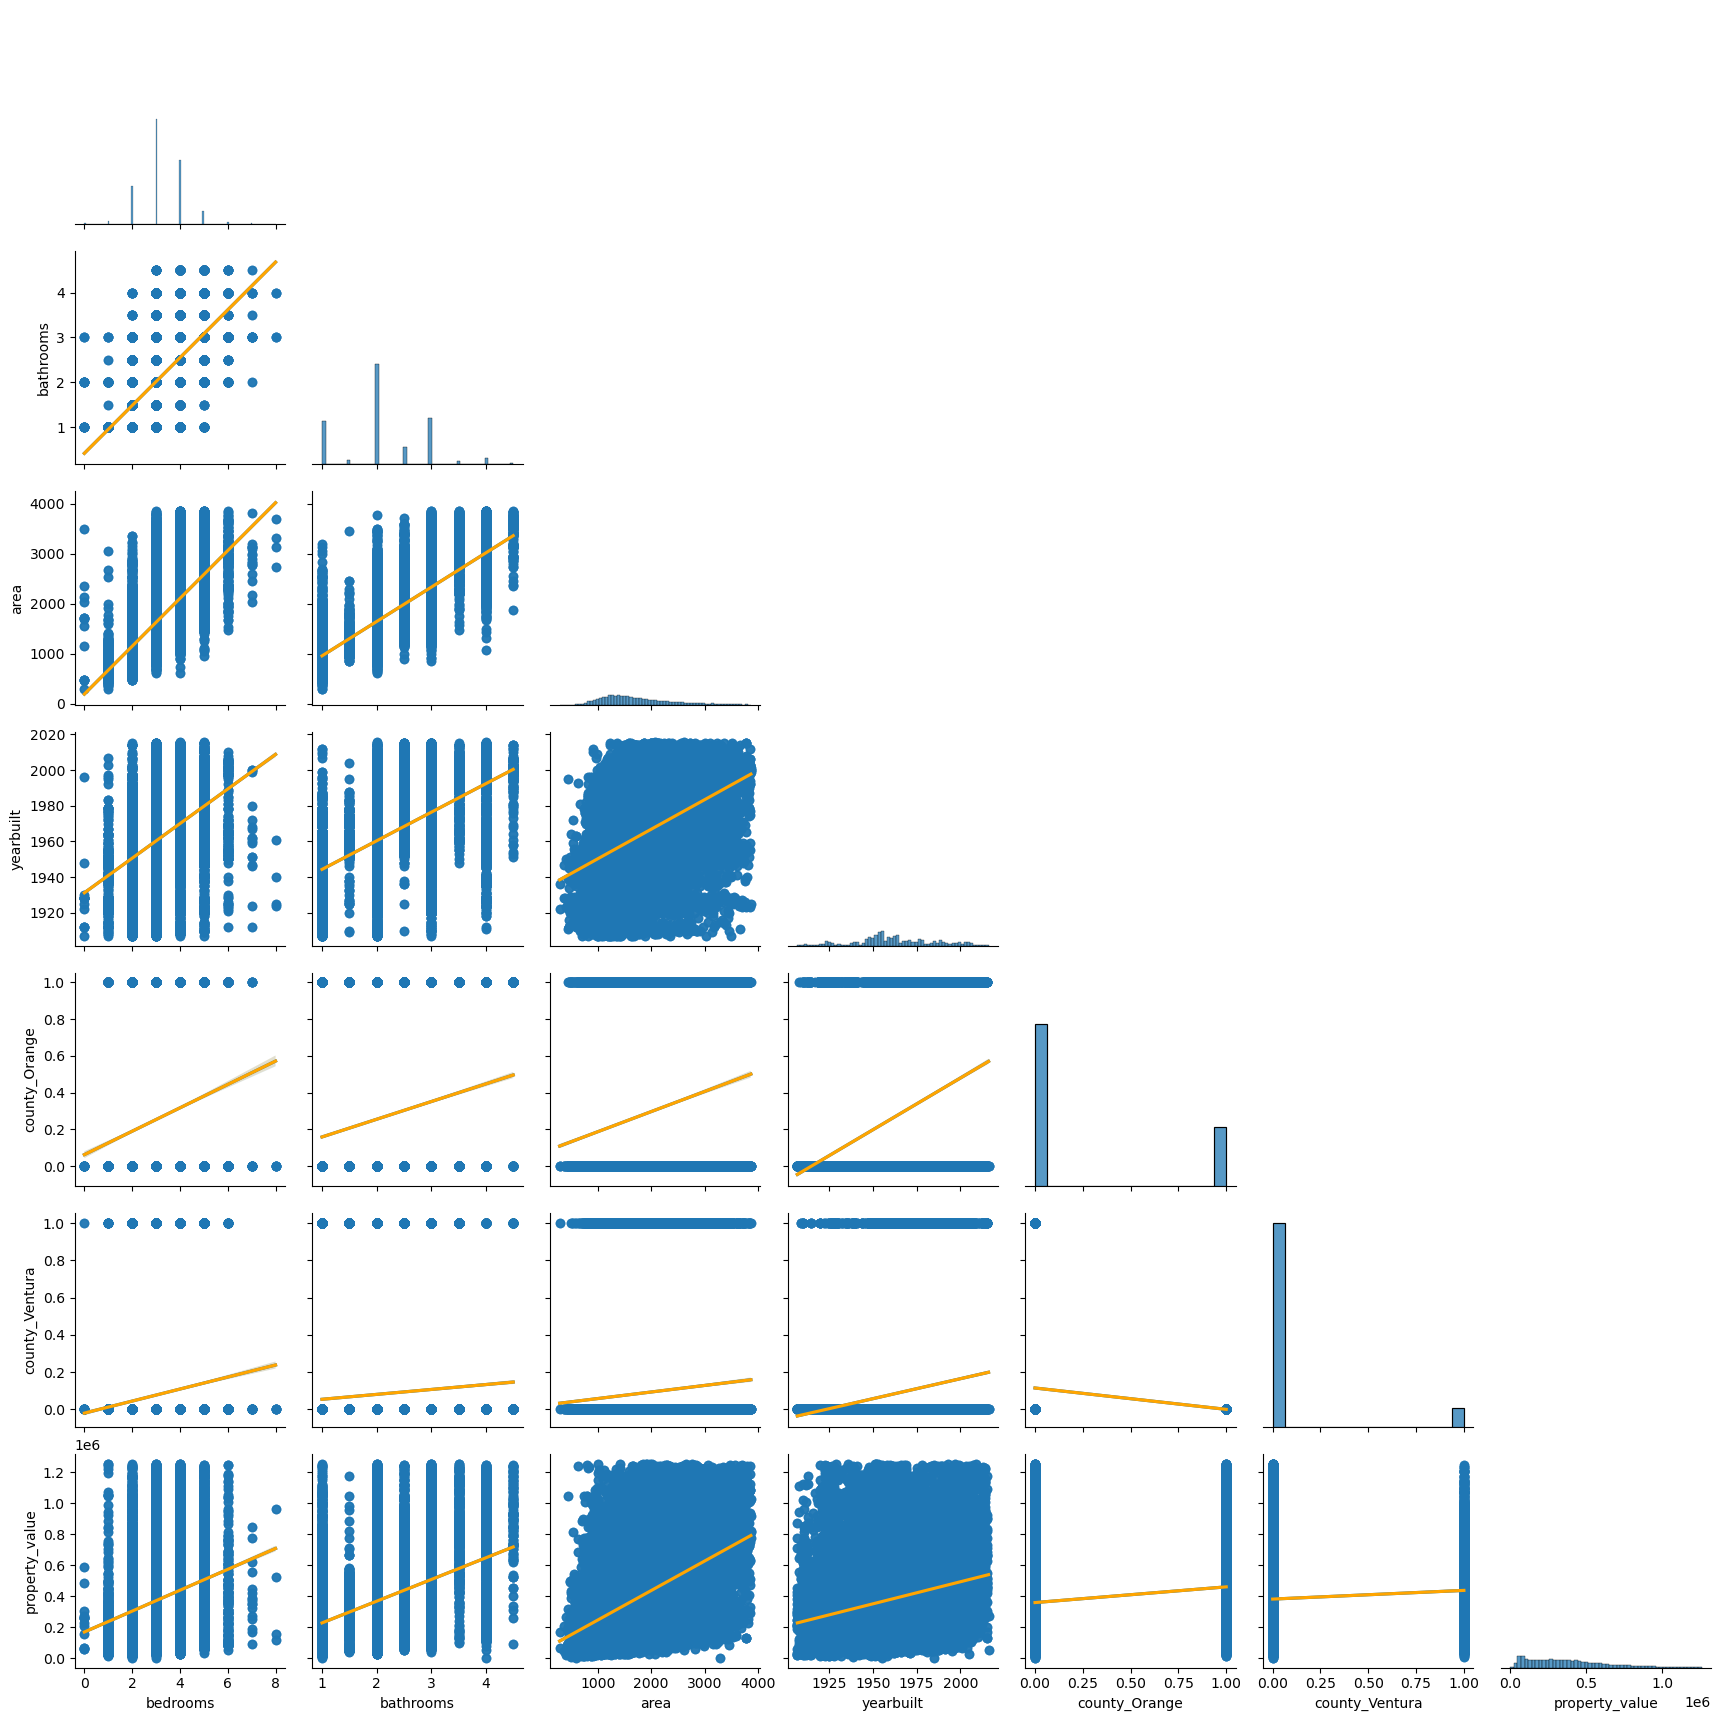

In [8]:
e.plot_variable_pairs(tr_smpl)

## 1. Does the location of a property impact its assessed value?

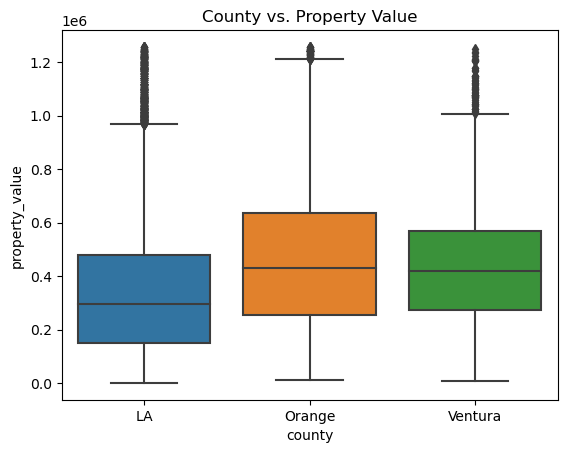

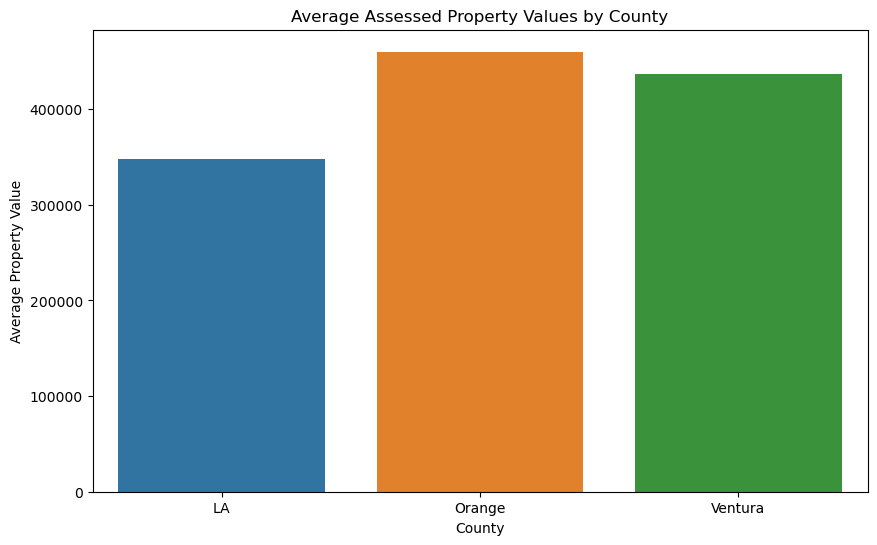

In [9]:
e.get_qone_chart(tr_smpl)

Hypothesis Test:
>Null Hypothesis (H0): The location of a property does not have a significant impact on its assessed value.

>Alternative Hypothesis (HA): The location of a property has a significant impact on its assessed value.

In [10]:
# Perform one-way ANOVA and Kruskal-Wallis test
e.get_anova_n_kruskal_test(tr_smpl)

Kruskal-Wallis - p-value: 5.330446174857006e-271
We reject the null hypothesis


### Summary:

The location assessed value matter of where you choose to live. Orange county has the highest property value and LA the lowest. 

## 2. How does the square footage of a property relate to its assessed value?

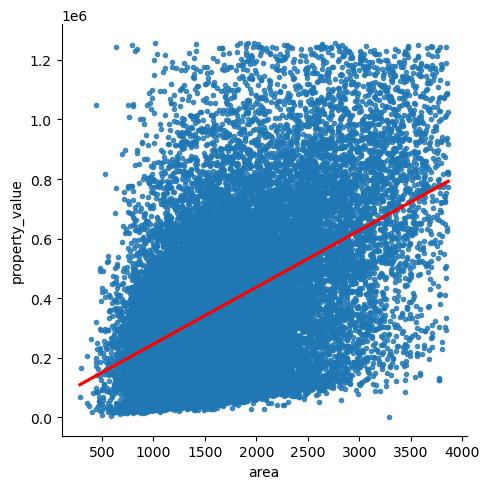

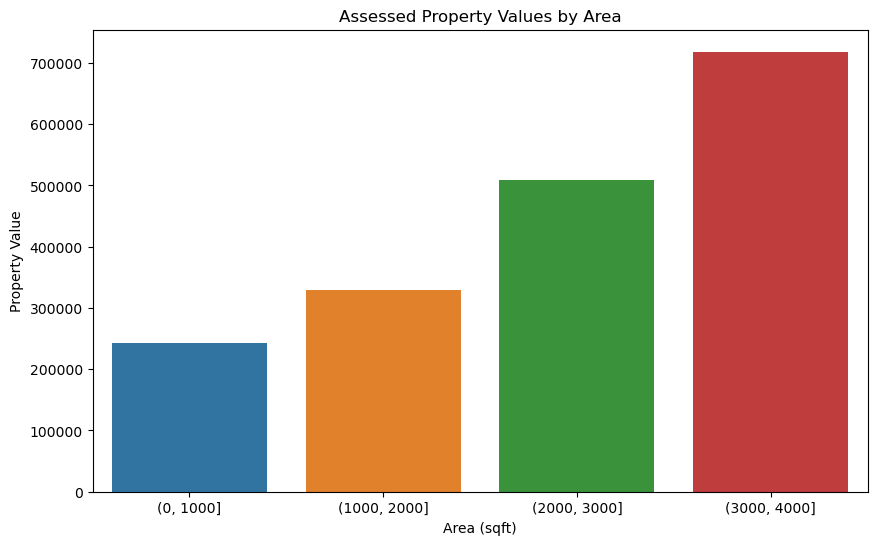

In [11]:
e.get_qtwo_chart(tr_smpl)

>Null Hypothesis (H0): There is NO significant correlation between the square footage of a property and its assessed value.

>Alternative Hypothesis (HA): There IS a significant correlation between the square footage of a property and its assessed value.

In [12]:
e.get_qtwo_stats(tr_smpl)

Pearson correlation - p-value: 0.0
We reject the null hypothesis

Correlation between area and property value
  r = 0.4802


### Summary:

There is a significant difference between the area of a property and the value. 

## 3. What is the relationship between the number of bedrooms/bathrooms and the assessed value?

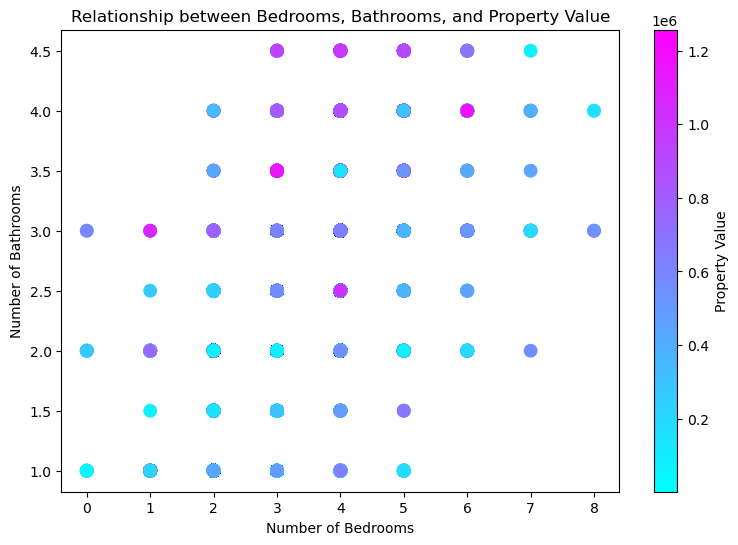

In [13]:
e.get_qthree_chart(tr_smpl)

>Null Hypothesis (H0): There is NO relationship between the number of bedrooms/bathrooms and the property value.

>Alternative Hypothesis (HA): There is a relationship between the number of bedrooms/bathrooms and the property value.

In [14]:
e.get_qthree_stats(tr_smpl)


ANOVA - p-value: 0.0
We reject the null hypothesis



,bedrooms,bathrooms,property_value
bedrooms,1.000000,0.602067,0.221779
bathrooms,0.602067,1.000000,0.408730
property_value,0.221779,0.408730,1.000000


### Summary:

Properties with a higher number of bedrooms or bathrooms have a significantly different assessed value compared to properties with fewer bedrooms or bathrooms.

### 4. Does the year built of a property affect its assessed value? Are newer properties generally assessed at higher values?

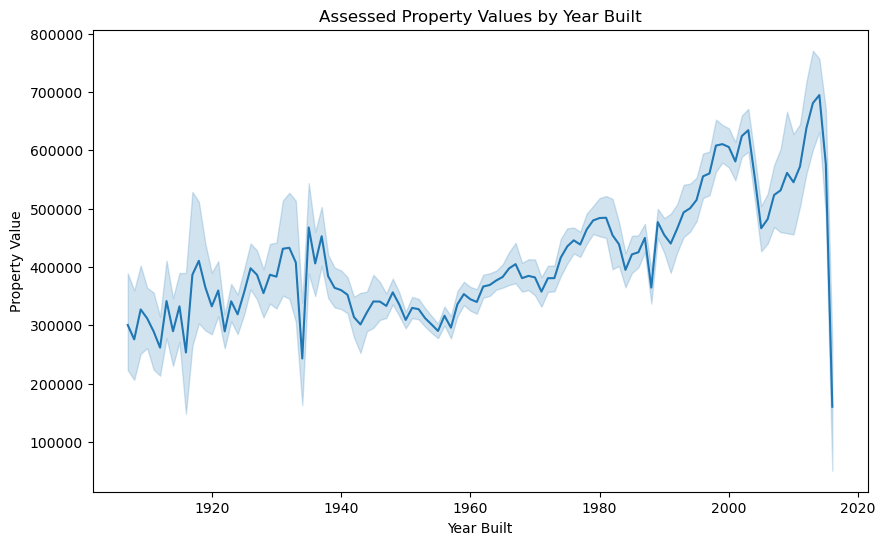

In [15]:
e.get_qfour_chart(tr_smpl)

>Null Hypothesis (H0): There is NOT a significant difference in the assessed values of newer and older properties.

>Alternative Hypothesis (HA): There IS a significant difference in the assessed values of newer and older properties.

In [16]:
e.get_qfour_stats(tr_smpl)


t-test - p-value: 0.0
We reject the null hypothesis



### Summary:

The age of a house has a significant impact on its value. Newer houses are becoming more expensive while older ones are decreasing in value.

## MODELING

In [17]:
X_tr, X_val, X_ts, y_tr, y_val, y_ts, to_scale, baseline = m.get_Xs_ys_to_scale_baseline(tr, val, ts, target)

In [18]:
X_tr_sc, X_val_sc, X_ts_sc = m.scale_data(X_tr,X_val,X_ts,to_scale)

In [19]:
metrics_df = m.get_models_dataframe(baseline,tr,y_tr,y_val,y_ts,X_tr_sc,X_val_sc,X_ts_sc)
metrics_df

,model,rmse val,r2 val
0,baseline,2.628774e+05,0.000000e+00
1,ols+RFE,2.293786e+05,2.432494e-01
2,ols,2.274820e+05,2.557116e-01
3,lars,2.274808e+05,2.557198e-01
4,poly_2D,2.227616e+05,2.862802e-01
5,poly_3D,2.239871e+05,2.784053e-01
6,poly_4D,2.216701e+05,2.932574e-01
7,poly_5D,2.224522e+05,2.882611e-01
8,poly_6D,2.452022e+05,1.352392e-01
9,poly_7D,5.004665e+05,-2.602444e+00


In [20]:
best_model = m.get_best_model(baseline, tr, y_tr, y_val, y_ts, X_tr_sc, X_val_sc, X_ts_sc)
best_model

,best model,rmse,r2
0,poly_4D,221670.069167,0.293257


In [21]:
result = m.test_best_model(best_model, X_ts_sc, y_ts, X_tr_sc, y_tr)
result

,model,rmse,r2
0,test,224946.655615,0.28798


### Conclusion

During the exploration, it was found that the property's location, the square footage, the number of bedrooms/bathrooms, and the year built impacted the property tax assessed value. It was also found that the properties were located in California in Los Angels, Ventura, and Orange counties. 

 • Orange County has a higher property value incomparable to LA and Ventura County.
 
 • The higher the square footage of a property, the higher the property value. 
 
 • The property value is related to the number of bedrooms/bathrooms, the more you have, the higher the value.
 
 • Newer properties have a higher value. 

In the modeling process, the Polynomial model with 4 degrees was the most effective model for predicting the property value.

### Recommendations

Based on the findings, removing as many outliers as possible is recommended, as testing several models and using algorithms to show the best models.

### Next Steps

The next steps include comparing the train RMSE vs the validate RMSE and further exploring other features. 